# Average density profiles

Plot time-averaged density profiles and their standard deviation.

#### Import libraries

In [1]:
%matplotlib notebook
from IPython.core.display import display, HTML
from ipfnpytools.getsig import getsig
import ipfnpytools.aug_read as aug_read
from ipfnpytools.closest import closest
from __future__ import print_function
from ipfnpytools.plot import plots
from warnings import warn
import numpy as np
from ipfnpytools.save_figure import save_figure
from ipfnpytools import rps_dump
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets#### Import libraries
import pandas as pd
import reflectometry as rfl
from ipfnpytools.trz_to_rhop import trz_to_rhop

### <span style="color:blue">Parameters</span>

In [2]:
# Shot number
shot = 37750

# Choose edition for reflectometry (0 for most recent)
edition = 0

# Choose profile source between 'afs' and 'dump'
source = 'afs'

# Path to dump file 
path = "/afs/ipp-garching.mpg.de/home/d/danielhfc/lab_rot/phd_part8_faitch_initializations/xhfs_2sep-0m050_xlfs_2m230.37765" 

# Signal to overlay the density profiles
support_signal = ('FPG', 'delRoben')

# Choose edition for the supporting signal (0 for most recent)
support_signal_edition = 0

# Magnetic equillibrium
equillibrium = "EQH"

# Number of density profiles to show in the plots
number_of_profiles = 3

# Size of window to average profiles [ms]
time_window = 100

# Show error bars corresponding to the standard deviation of the average profile
show_std = True

# Show HFS and LFS rho profiles in the same window
show_same = False

# Show wall
show_wall = True

### Load support signal from AFS

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgnl (8.1): no calibration of data
  warnings.warn(err_txt, RuntimeWarning)


<IPython.core.display.Javascript object>


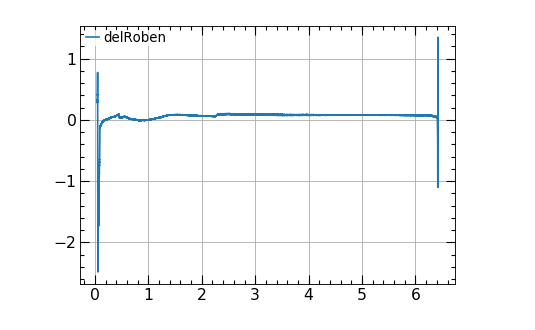

(<Figure size 535.433x330.916 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b3087db0690>)

In [3]:
signal = getsig(shot, support_signal[0], support_signal[1], edition=support_signal_edition)
plots(signal.time, signal.data, labels=signal.name)

### Fetch density profile data

In [4]:
time, lfs_signal, hfs_signal, lfs_area, hfs_area = rfl.fetch(shot, path if source=='dump' else None, verbose=False)

# Unit conversion
lfs_signal*=1e-19
hfs_signal*=1e-19

# Remove NaN's
lfs_area = np.nan_to_num(lfs_area)
hfs_area = np.nan_to_num(hfs_area)

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgrp (8.1): No PARAM_SET found
  warnings.warn(err_txt, RuntimeWarning)


### Compute the average and standard deviation

In [5]:
N = int(time_window*1e-3 / (time[1] - time[0]))
print("Averaging %d profiles on a %.3lf ms window." % (N, time_window))

lfs_average = pd.DataFrame(lfs_area).rolling(window=N).mean().values
hfs_average = pd.DataFrame(hfs_area).rolling(window=N).mean().values

lfs_std = pd.DataFrame(lfs_area).rolling(window=N).std().values
hfs_std = pd.DataFrame(hfs_area).rolling(window=N).std().values

Averaging 571 profiles on a 100.000 ms window.


### Plot density vs. R \[m\]

<IPython.core.display.Javascript object>


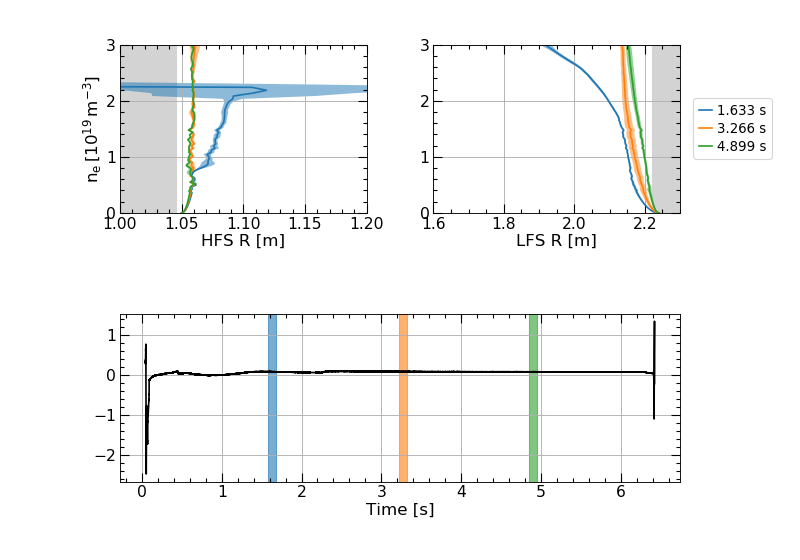

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTQuODk4NjgyNTk0Mjk5MzE2LCBkZXNjcmlwdGlvbj11J1RpbWUgW3NdJywgbWF4PTYuNDIzNjI5NzYwNzQyMTg3NSwgbWnigKY=


In [6]:
fig1, ax1, ax2, ax3 = rfl.two_plus_one(
    x1=signal.time, y1=signal.data, 
    x23=time, y2=hfs_average, y3=lfs_average, 
    z2=hfs_signal, z3=lfs_signal, 
    ey2=hfs_std if show_std else None, 
    ey3=lfs_std if show_std else None,
    lx1="Time [s]", ly1='',
    ly2="HFS R [m]", lz2=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    ly3="LFS R [m]", lz3=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    number_of_profiles=number_of_profiles, 
    m2=None, m3=None, 
    strip_pts=N, show_same=False, 
    paint_rho=False, paint_wall=True,
    sharex=False, sharey=True,
)

## <span style="color:blue">Parameters</span>
Change the above figure manualy with your cursor, or by running the following cell

In [7]:
fig1.set_size_inches(10, 7)  # Figure size in inches (widht, height)

ax1.set_xlim(None, None)  # Bottom plot x-range
ax1.set_ylim(None, None)  # Bottom plot y-range

ax2.set_xlim(1, 1.2)  # Top-left plot x-range
ax2.set_ylim(0, 3)  # Top-left plot y-range

ax3.set_xlim(1.6, 2.3) # Top-right plot x-range
ax3.set_ylim(0, 3)  # Top-right plot y-range

(0, 3)

### Save the figure to your working directory

In [8]:
save_figure(fig1, "%d_average_profiles" % (shot))

Figure saved to /afs/ipp-garching.mpg.de/home/d/danielhfc/python/AUG/37750_average_profiles.png


### Convert R \[m\] to $\rho$ and compute the average and std.

In [9]:
# Set the antenna Z
zl = 0.14
zh = 0.07

# Walls
inner_wall = 1.045
outer_wall = 2.22

inner_wall_rho = trz_to_rhop(time, inner_wall, zh, shot, eq=equillibrium)
outer_wall_rho = trz_to_rhop(time, outer_wall, zl, shot, eq=equillibrium)

rhol = trz_to_rhop(time, lfs_area, np.ones_like(lfs_area)*zl, shot, eq=equillibrium)
rhoh = trz_to_rhop(time, hfs_area, np.ones_like(hfs_area)*zh, shot, eq=equillibrium)

# Remove NaNs  ---------------------------------------------
rhol = np.nan_to_num(rhol)
rhoh = np.nan_to_num(rhoh)

# Compute the average and std in rho ------------------------

rhol_average = pd.DataFrame(rhol).rolling(window=N, center=True).mean().values
rhoh_average = pd.DataFrame(rhoh).rolling(window=N, center=True).mean().values

rhol_std = pd.DataFrame(rhol).rolling(window=N, center=True).std().values
rhoh_std = pd.DataFrame(rhoh).rolling(window=N, center=True).std().values

trz_to_rhop:37323/37323
trz_to_rhop:37323/37323
trz_to_rhop:37323/37323
trz_to_rhop:37323/37323


### Plot density vs. $\rho$

<IPython.core.display.Javascript object>


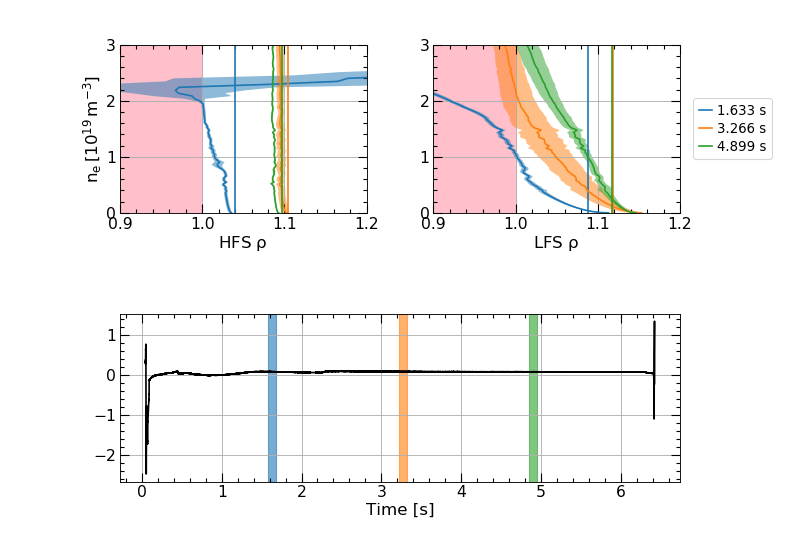

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTQuODk4NjgyNTk0Mjk5MzE2LCBkZXNjcmlwdGlvbj11J1RpbWUgW3NdJywgbWF4PTYuNDIzNjI5NzYwNzQyMTg3NSwgbWnigKY=


(0, 3)

In [10]:
fig2, ax4, ax5, ax6 = rfl.two_plus_one(
    x1=signal.time, y1=signal.data, 
    x23=time, y2=rhoh_average, y3=rhol_average, 
    z2=hfs_signal, z3=lfs_signal, 
    ey2=rhoh_std if show_std else None, 
    ey3=rhol_std if show_std else None,
    lx1="Time [s]", ly1='',
    ly2=r"$\rho$" if show_same else r"HFS $\rho$",### Plot density vs. $\rho$ 
    lz2=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    ly3=r"LFS $\rho$", lz3=r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$',
    number_of_profiles=number_of_profiles, 
    m2=inner_wall_rho if show_wall else None, 
    m3=outer_wall_rho if show_wall else None, 
    strip_pts=N, show_same=show_same, 
    paint_rho=True, paint_wall=False,
    sharex=False, sharey=True,
)


# *** PARAMETERS ***
# Plotting options. `None` means automatic

fig2.set_size_inches(10, 7)

ax4.set_xlim(None, None)  # Bottom plot x-range
ax4.set_ylim(None, None)  # Bottom plot y-range

ax5.set_xlim(0.9, 1.2)  # Top-left plot x-range
ax5.set_ylim(0, 3)  # Top-left plot y-range

ax6.set_xlim(0.9, 1.2) # Top-right plot x-range
ax6.set_ylim(0, 3)  # Top-right plot y-range

## <span style="color:blue">Parameters</span>
Change the figure manualy with your cursor, or by running the following cell

In [11]:
fig2.set_size_inches(10, 7)  # Figure size in inches (width, height)

ax4.set_xlim(None, None)  # Bottom plot x-range
ax4.set_ylim(None, None)  # Bottom plot y-range

ax5.set_xlim(0.9, 1.2)  # Top-left plot x-range
ax5.set_ylim(0, 3)  # Top-left plot y-range

ax6.set_xlim(0.9, 1.2) # Top-right plot x-range
ax6.set_ylim(0, 3)  # Top-right plot y-range

(0, 3)

### Save the figure to your working directory

In [12]:
save_figure(fig2, "%d_average_profiles_rho" % (shot))

Figure saved to /afs/ipp-garching.mpg.de/home/d/danielhfc/python/AUG/37750_average_profiles_rho.png
